In [17]:
import numpy as np
import requests
import re
import matplotlib.pyplot as plt

In [2]:
#We fetch a plain text version of an online book and prepare and tokenize the entire book

## Get text from web

In [3]:
# get raw text(book) from internet
book = requests.get('https://www.gutenberg.org/files/35/35-0.txt')

#extratc just the text and have a look
text = book.text
print(type(text))
print(len(text))

text[:2000]

<class 'str'>
182973


'*** START OF THE PROJECT GUTENBERG EBOOK 35 ***\r\n\r\n\r\n\r\n\r\nThe Time Machine\r\n\r\nAn Invention\r\n\r\nby H. G. Wells\r\n\r\n\r\nCONTENTS\r\n\r\n I Introduction\r\n II The Machine\r\n III The Time Traveller Returns\r\n IV Time Travelling\r\n V In the Golden Age\r\n VI The Sunset of Mankind\r\n VII A Sudden Shock\r\n VIII Explanation\r\n IX The Morlocks\r\n X When Night Came\r\n XI The Palace of Green Porcelain\r\n XII In the Darkness\r\n XIII The Trap of the White Sphinx\r\n XIV The Further Vision\r\n XV The Time Traveller’s Return\r\n XVI After the Story\r\n Epilogue\r\n\r\n\r\n\r\n\r\n I.\r\n Introduction\r\n\r\n\r\nThe Time Traveller (for so it will be convenient to speak of him) was\r\nexpounding a recondite matter to us. His pale grey eyes shone and\r\ntwinkled, and his usually pale face was flushed and animated. The fire\r\nburnt brightly, and the soft radiance of the incandescent lights in the\r\nlilies of silver caught the bubbles that flashed and passed in our\r\nglas

In [4]:
# remove unwated chara
# char to replace with space

strings2replace = [
                    '\r\n\r\nâ\x80\x9c',
                    'â\x80\x9c',
                    'â\x80\x9d',
                    '\r\n',
                    'â\x80\x94',
                    'â\x80\x99',
                    'â\x80\x98',
                    '_',]

for str2match in strings2replace:
    regexp = re.compile(r'%s'%str2match)
    text = regexp.sub('.',text)

# remove non-ascii char
text = re.sub(r'[^\x00-\x7F]+',' ',text)

#remove numbers
text = re.sub('\d+','',text)

#and make everything lower case
text =text.lower()

text[:2000]

'*** start of the project gutenberg ebook  ***.....the time machine..an invention..by h. g. wells...contents.. i introduction. ii the machine. iii the time traveller returns. iv time travelling. v in the golden age. vi the sunset of mankind. vii a sudden shock. viii explanation. ix the morlocks. x when night came. xi the palace of green porcelain. xii in the darkness. xiii the trap of the white sphinx. xiv the further vision. xv the time traveller s return. xvi after the story. epilogue..... i.. introduction...the time traveller (for so it will be convenient to speak of him) was.expounding a recondite matter to us. his pale grey eyes shone and.twinkled, and his usually pale face was flushed and animated. the fire.burnt brightly, and the soft radiance of the incandescent lights in the.lilies of silver caught the bubbles that flashed and passed in our.glasses. our chairs, being his patents, embraced and caressed us rather.than submitted to be sat upon, and there was that luxurious.after-

## Parse text into words

In [5]:
# split by punctuation
import string
print(string.punctuation)
puncts4re = f'[{string.punctuation}\s]+'

words = re.split(puncts4re,text)
words = [item.strip() for item in words if item.strip()] #remove spaces in words

# remove single chara words
words = [item for item in words if len(item)>1]

words[:50]

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


['start',
 'of',
 'the',
 'project',
 'gutenberg',
 'ebook',
 'the',
 'time',
 'machine',
 'an',
 'invention',
 'by',
 'wells',
 'contents',
 'introduction',
 'ii',
 'the',
 'machine',
 'iii',
 'the',
 'time',
 'traveller',
 'returns',
 'iv',
 'time',
 'travelling',
 'in',
 'the',
 'golden',
 'age',
 'vi',
 'the',
 'sunset',
 'of',
 'mankind',
 'vii',
 'sudden',
 'shock',
 'viii',
 'explanation',
 'ix',
 'the',
 'morlocks',
 'when',
 'night',
 'came',
 'xi',
 'the',
 'palace',
 'of']

In [6]:
# create te vocab
vocab = sorted(set(words))

# convenience variables for later
nWords = len(words)
nLex = len(vocab)

print(f'{nWords} words')
print(f'{nLex} unique words')

30698 words
4589 unique words


## Create token dict and encoder/decoder func


In [7]:
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for i,w in enumerate(vocab)}

for i in list(word2idx.items())[0:10000:87]:
    print(i)

('abandon', 0)
('aimlessly', 87)
('apologise', 174)
('attained', 261)
('behaved', 348)
('both', 435)
('can', 522)
('cheerfully', 609)
('coat', 696)
('contents', 783)
('culminating', 870)
('delay', 957)
('dimness', 1044)
('dragging', 1131)
('edition', 1218)
('everywhere', 1305)
('facilities', 1392)
('find', 1479)
('footfall', 1566)
('furnishing', 1653)
('gold', 1740)
('hallo', 1827)
('high', 1914)
('ideas', 2001)
('inextinguishable', 2088)
('invest', 2175)
('lamp', 2262)
('likewise', 2349)
('manhood', 2436)
('minerals', 2523)
('mysteries', 2610)
('novelty', 2697)
('outbreaks', 2784)
('paws', 2871)
('plato', 2958)
('previously', 3045)
('questionings', 3132)
('reflecting', 3219)
('return', 3306)
('sandals', 3393)
('senses', 3480)
('shrinking', 3567)
('slit', 3654)
('special', 3741)
('stick', 3828)
('sudden', 3915)
('tap', 4002)
('thrice', 4089)
('treat', 4176)
('unfrozen', 4263)
('vertical', 4350)
('wearisome', 4437)
('wonderful', 4524)


In [8]:
def encoder(words, encode_dict):
    # init a vector of numerical indices
    idxs = np.zeros(len(words), dtype=int)

    # loop through words and find their token in vocab
    for i,w in enumerate(words):
        idxs[i] = encode_dict[w]

    return idxs

def decoder(idxs,decode_dict):
    return ' '.join([decode_dict[i] for i in idxs])
    

In [10]:
print(encoder(['the','time','machine'], word2idx))

print(decoder([4042, 4109, 2416],idx2word))

[4042 4109 2416]
the time machine


In [13]:
# random tokens
randomTokens = np.random.randint(0, len(vocab),10)

# test with random token indicesa
print(f'Radnom tokens: \n\t {randomTokens}\n')
print(f'Decoded text: \n\t{decoder(randomTokens, idx2word)}')

Radnom tokens: 
	 [ 306 2053 2633 3498 1365 2613 1836 4389  828 1323]

Decoded text: 
	barometer inclination necessarily sets exposition mystic hanged walk covered exchange


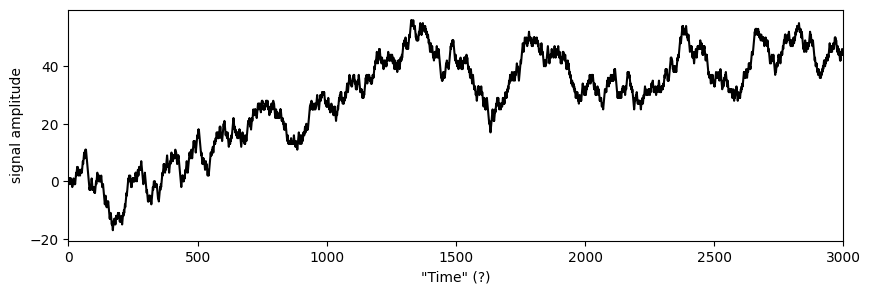

In [19]:
## PEAK INTO BROWNIAN NOISE

brownNoise = np.cumsum(np.random.choice([-1,1],3000))

plt.figure(figsize=(10,3))
plt.plot(brownNoise,'k')
plt.gca().set(xlim=[0,len(brownNoise)],xlabel = '"Time" (?)',ylabel='signal amplitude')
plt.show()

In [21]:
nLex  #lenght of vocab

4589

In [29]:
# BROWNIAN NOISE

brownNoise = np.cumsum(np.random.choice([-1,1],30))   # cumsum of random 30 +1 and -1s
print(brownNoise)

BrownianRandomTokens = brownNoise + np.random.choice(nLex,1)
print(BrownianRandomTokens)
print(' ')

#test with random token indices
print(f'Brownina random tokens: \n\t{BrownianRandomTokens}\n')
print(f'Decoded Text: \n\t{decoder(BrownianRandomTokens,idx2word)}')

[ 1  2  1  2  1  0 -1 -2 -1 -2 -3 -2 -3 -4 -3 -4 -3 -2 -1 -2 -3 -2 -3 -4
 -5 -4 -3 -4 -3 -4]
[3208 3209 3208 3209 3208 3207 3206 3205 3206 3205 3204 3205 3204 3203
 3204 3203 3204 3205 3206 3205 3204 3205 3204 3203 3202 3203 3204 3203
 3204 3203]
 
Brownina random tokens: 
	[3208 3209 3208 3209 3208 3207 3206 3205 3206 3205 3204 3205 3204 3203
 3204 3203 3204 3205 3206 3205 3204 3205 3204 3203 3202 3203 3204 3203
 3204 3203]

Decoded Text: 
	recovery red recovery red recovery recovered recover records recover records recorded records recorded record recorded record recorded records recover records recorded records recorded record recondite record recorded record recorded record


In [23]:
brownNoise

array([-1, -2, -3, -4, -3, -4, -5, -4, -3, -4, -3, -2, -1, -2, -1, -2, -3,
       -2, -1,  0,  1,  2,  1,  0, -1, -2, -3, -2, -3, -4])

In [25]:
a=np.array([1,2,3])
a+np.random.choice(nLex,1)

array([3398, 3399, 3400])

In [27]:
np.random.choice(nLex,1)

array([2058])

## Distribution of word lenghts

[[<matplotlib.axis.XTick at 0x11f2a0580>,
 (0.0, 16.0),
 Text(0.5, 0, 'Number of charecters'),
 Text(0, 0.5, 'Token Count'),
 Text(0.5, 1.0, 'Histogram of charcter count freqs')]

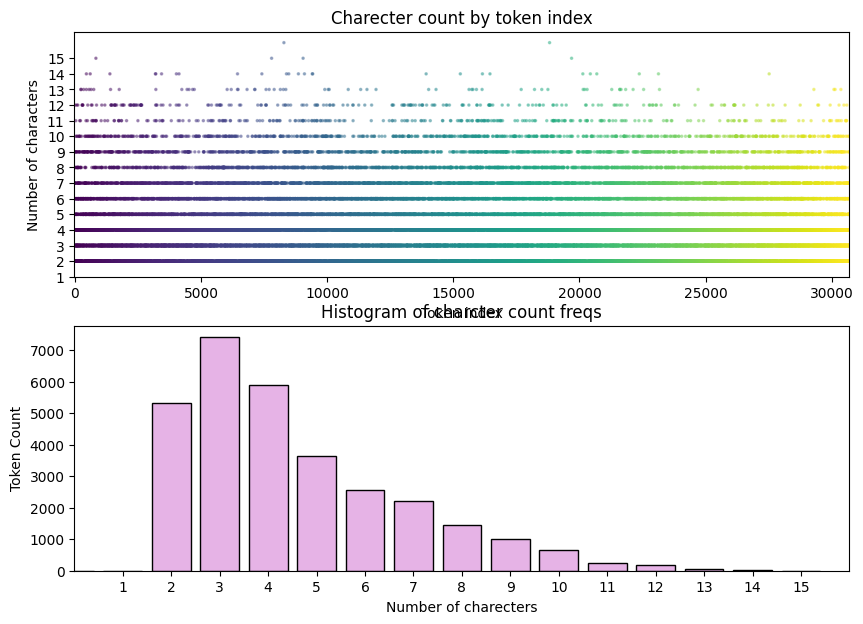

In [33]:
# distribution of word length

# loop through words and count the charecter per word
numChars = np.zeros(nWords)
for i,w in enumerate(words):
    numChars[i] = len(w)

#now count the numbver of words with those characters
charCounts = np.zeros(int(np.max(numChars)))
for i in range(len(charCounts)):
    charCounts[i] = np.sum(numChars==i)

#and plot
_,axs = plt.subplots(2,1,figsize=(10,7))
axs[0].scatter(range(nWords),numChars,marker='.',s=10,c=np.linspace(.1,.9,len(numChars)),alpha=.4)
axs[0].set(yticks=range(1,int(np.max(numChars))),xlabel='Token index',xlim=[-15,nWords],
           ylabel='Number of characters',title='Charecter count by token index')

axs[1].bar(range(len(charCounts)), charCounts,edgecolor='k',color=[.9,.7,.9])
axs[1].set(xticks=range(1,len(charCounts)),xlim=[0,len(charCounts)],xlabel='Number of charecters',
           ylabel='Token Count',title='Histogram of charcter count freqs')



## Trying to tokenize words outside of vocab

In [34]:
# a sentence which has atleast 1 word that doesnot appear in the vocab
sentence = 'The space aliens  came to Earth to steal watermelons and staplers.'

#preprocess (remove punctuation, make lower case, split into words)
words_new = re.split(f'[,.\s]+',sentence.lower())

#remove empty items
words_new = [item.strip() for item in words_new if item.strip()]
words_new

['the',
 'space',
 'aliens',
 'came',
 'to',
 'earth',
 'to',
 'steal',
 'watermelons',
 'and',
 'staplers']

In [35]:
#toeknize (uh,oh..)
encoder(words_new, word2idx)

KeyError: 'aliens'

## New encoder


In [38]:
# here new tokens not in vocab encoded as <UNK>

word2idx_new = word2idx.copy()
idx2word_new = idx2word.copy()

#add an entry for unknown words
word2idx_new['<|unk|>']=len(word2idx)+1
idx2word_new[len(idx2word)+1] = '<|unk|>'

def encoder_new(words, encode_dict):
    # init a vector of numerical indices
    idxs = np.zeros(len(words), dtype=int)

    # loop through words and find their token in vocab
    for i,w in enumerate(words):
        if w in encode_dict:
            idxs[i] = encode_dict[w]
        else:
            idxs[i] = encode_dict['<|unk|>']

    return idxs    

In [39]:
tokenidx = encoder_new(words_new, word2idx_new)
tokenidx

array([4042, 3734, 4590,  519, 4119, 1191, 4119, 4590, 4590,  137, 4590])

In [40]:
words_new

['the',
 'space',
 'aliens',
 'came',
 'to',
 'earth',
 'to',
 'steal',
 'watermelons',
 'and',
 'staplers']

In [41]:
decoder(tokenidx, idx2word_new)

'the space <|unk|> came to earth to <|unk|> <|unk|> and <|unk|>'